In [83]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from my_utils import load_data
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [3]:
X, session_df, requests_df = load_data(csv_path='output.log', req_thres=5, normalize_feat=True)

LOADING THE DATASET...


Skipping line 601729: Expected 7 fields in line 601729, saw 23. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


DATASET HAS BEEN LOADED SUCESSFULLY!


In [4]:
session_df.reset_index(inplace=True)

In [5]:
X['is_bot'] = X['is_bot'].astype(int)
X['is_pc'] = X['is_pc'].astype(int)

X.reset_index(inplace=True)

to_model_cols = X.columns[2:16]

X_train, X_test = train_test_split(X[to_model_cols], test_size=0.2, random_state=42)

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (25232, 14)
X_test shape: (6309, 14)


In [6]:
X_train.columns

Index(['requests_count', 'path_length_std', '4xx_percentage(%)',
       '3xx_percentage(%)', 'HEAD_count(%)', 'image_count(%)',
       'total_response_length', 'mean_response_length', 'total_response_time',
       'mean_response_time', 'avg_path_count_norm', 'is_bot', 'is_pc',
       'avg_time_diff'],
      dtype='object')

# Auto encoder model

In [7]:
input_dim = X_train.shape[1] # the # features
encoding_dim = input_dim # first layer
hidden_dim = int(encoding_dim / 2) #hidden layer


# model architecture
input_layer = Input(shape=(input_dim))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                210       
Total params: 637
Trainable params: 637
Non-trainable params: 0
_________________________________________________________________


In [8]:
nb_epoch = 25
batch_size = 64

checkpoint_filepath = 'checkpoints/autoencoder_weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(X_test, X_test),
                    verbose=1, callbacks=[model_checkpoint_callback])

Epoch 1/25
395/395 [==============================] - 9s 2ms/step - loss: 0.6085 - acc: 0.3875 - val_loss: 0.8623 - val_acc: 0.7461
Epoch 2/25
395/395 [==============================] - 0s 809us/step - loss: 0.4506 - acc: 0.7570 - val_loss: 0.7578 - val_acc: 0.7985
Epoch 3/25
395/395 [==============================] - 0s 811us/step - loss: 0.3218 - acc: 0.7897 - val_loss: 0.6903 - val_acc: 0.8328
Epoch 4/25
395/395 [==============================] - 0s 817us/step - loss: 0.2684 - acc: 0.8486 - val_loss: 0.6567 - val_acc: 0.8650
Epoch 5/25
395/395 [==============================] - 0s 811us/step - loss: 0.2423 - acc: 0.8655 - val_loss: 0.6511 - val_acc: 0.8683
Epoch 6/25
395/395 [==============================] - 0s 864us/step - loss: 0.2439 - acc: 0.8872 - val_loss: 0.6492 - val_acc: 0.8608
Epoch 7/25
395/395 [==============================] - 0s 807us/step - loss: 0.1953 - acc: 0.8842 - val_loss: 0.6511 - val_acc: 0.8808
Epoch 8/25
395/395 [==============================] - 0s 786us/s

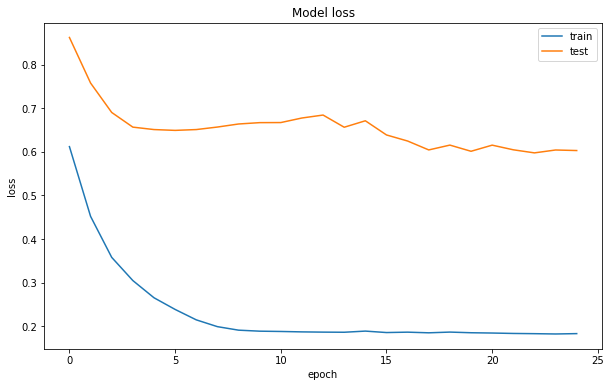

In [9]:
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [38]:
X_train.drop(columns=['mse'], axis=1, inplace=True)
X_test.drop(columns=['mse'], axis=1, inplace=True)

## Load the model

In [39]:
# load the best weights
autoencoder.load_weights(checkpoint_filepath)

train_preds = autoencoder.predict(X_train)
test_preds = autoencoder.predict(X_test)

#get the error term
mse_train = np.mean(np.power(X_train.to_numpy() - train_preds, 2), axis=1)
mse_test = np.mean(np.power(X_test.to_numpy() - test_preds, 2), axis=1)

X_train['mse'] = mse_train
X_test['mse'] = mse_test

In [40]:
mse_threshold = np.quantile(X_train['mse'], 0.98)
print('mse threshold is {}'.format(mse_threshold))

train_outliers = session_df.loc[X_train[X_train['mse'] > mse_threshold].sort_values(['mse'], ascending=False).index]
train_inliers = session_df.loc[X_train[X_train['mse'] < mse_threshold].sort_values(['mse'], ascending=True).index]

print('train outliers shape: {}'.format(train_outliers.shape))
print('train inliers shape: {}'.format(train_inliers.shape))

mse threshold is 0.3501863414163129
train outliers shape: (505, 18)
train inliers shape: (24727, 18)


In [33]:
test_outliers = session_df.loc[X_test[X_test['mse'] > mse_threshold].sort_values(['mse'], ascending=False).index]
test_inliers = session_df.loc[X_test[X_test['mse'] < mse_threshold].sort_values(['mse'], ascending=True).index]

print('test outliers shape: {}'.format(test_outliers.shape))
print('test inliers shape: {}'.format(test_inliers.shape))

test outliers shape: (124, 18)
test inliers shape: (6185, 18)


In [116]:
#ip = train_outliers.iloc[-21].ip
#ua = train_outliers.iloc[-21].user_agent

ip = '134.172.55.99'
ua = 'MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0' 

requests_df[(requests_df['ip'] == ip) & (requests_df['user_agent'] == ua)].sort_values('time_stamp', ascending=True).head(20)

,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized,path_length,time_stamp
486543,134.172.55.99,2021-05-12 10:57:09+04:30,Get,404,apple_touch_icon_120x120_precomposed.png,29827,MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0,8.0,0.017795,1,1620800829
486548,134.172.55.99,2021-05-12 10:57:09+04:30,Get,404,apple_touch_icon_120x120.png,29827,MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0,8.0,0.017795,1,1620800829
486553,134.172.55.99,2021-05-12 10:57:09+04:30,Get,404,apple_touch_icon_precomposed.png,29827,MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0,0.0,0.019164,1,1620800829
486559,134.172.55.99,2021-05-12 10:57:09+04:30,Get,404,apple_touch_icon.png,29827,MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0,0.0,0.026652,1,1620800829
486564,134.172.55.99,2021-05-12 10:57:09+04:30,Get,200,images/fav_icon2.ico,23531,MobileSafari/604.1 CFNetwork/1197 Darwin/20.0.0,4.0,1.508523,2,1620800829


# Human based evaluation

We decided to manually evaluate the predictions :) 

In [93]:
#outliers
outlier_index = train_outliers.set_index(['ip', 'user_agent'])[40:60].index
out_df = pd.DataFrame(index=outlier_index, columns={'label'}).fillna(-1)

#inliers
inlier_index = train_inliers.set_index(['ip', 'user_agent'])[60:90].index
in_df = pd.DataFrame(index=inlier_index, columns={'label'}).fillna(1)


dfs = [out_df, in_df]
merged_df = pd.concat(dfs)
merged_df = shuffle(merged_df, random_state=42)

# to save to the csv file in order to evaluate them manually later
merged_df.to_csv('mohammad.csv')

In [199]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [238]:
%matplotlib notebook

<IPython.core.display.Javascript object>


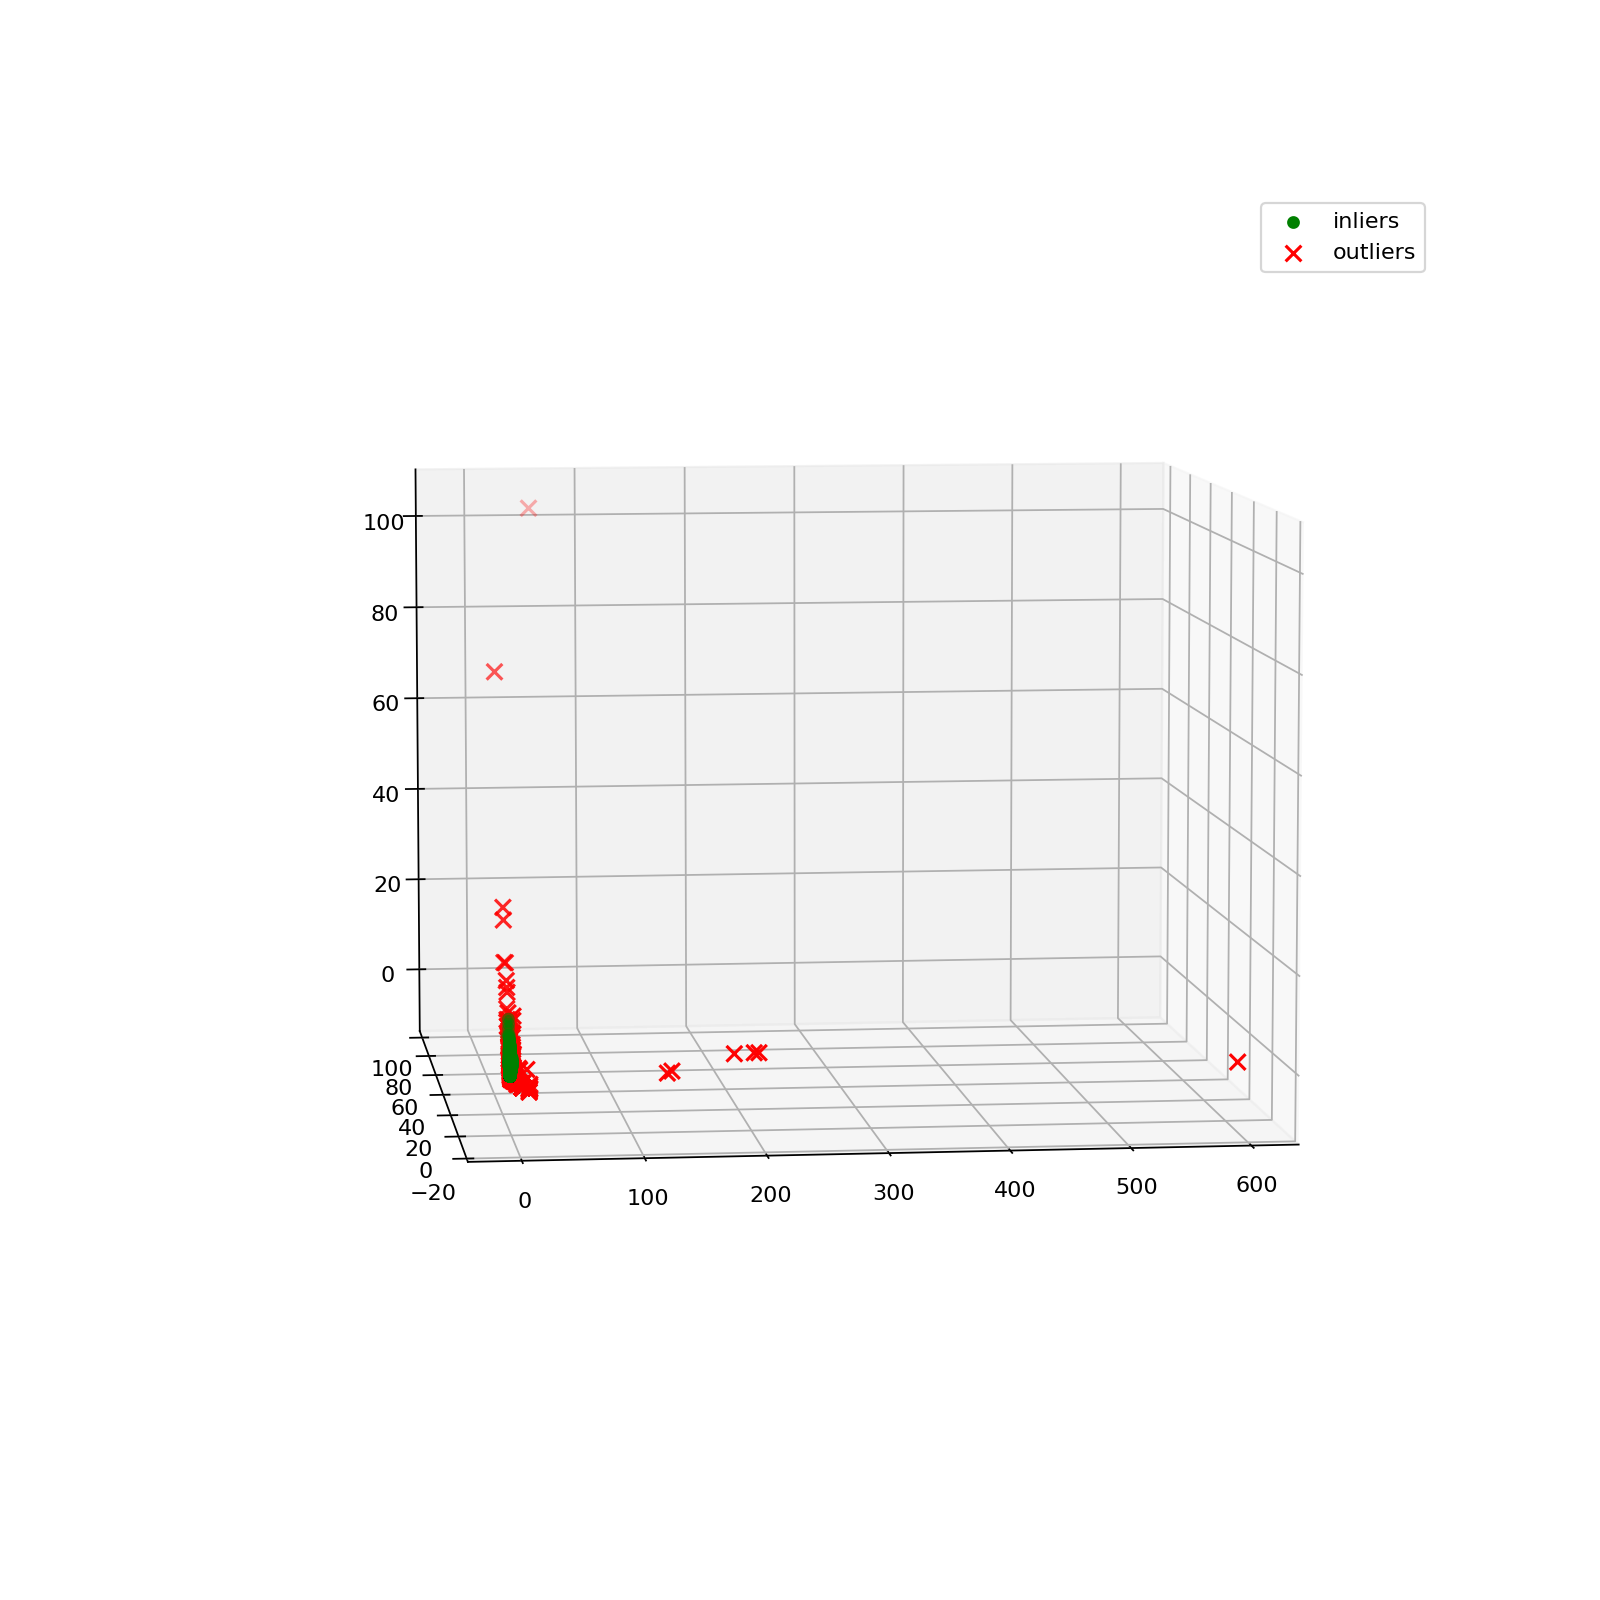

In [239]:
temp = X_train

temp.reset_index(inplace=True)
temp.drop(columns=['index'], inplace=True)


outlier_index = temp[temp['mse'] > mse_threshold].index
inlier_index = temp[temp['mse'] < mse_threshold].index


pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(temp)

fig = plt.figure(figsize=(10,10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

# Plot the compressed data points
ax.scatter(X_reduce[inlier_index, 0], X_reduce[inlier_index, 1], zs=X_reduce[inlier_index, 2], 
           s=14, lw=2, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=10, s=1, marker="x", c="red", label="outliers")

ax.legend()
plt.show()